<a href="https://colab.research.google.com/github/sasergeevna/python_projects.github.io/blob/main/AB_test_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Анализ A/B теста: Эффективность новой стратегии на лендинге
**Цель проекта:** Проверить статистическую значимость различий в конверсии между тестовой и контрольной группами для принятия решения о внедрении изменений;

**Бизнес-задача:** Тестирование нового дизайна лендинга для увеличения конверсии;

**Метрика успеха:** Увеличение conversion rate на 10+%;

**Период теста:** 01.08.2023 - 01.11.2023;

**Размер выборки:** 94778 пользователей;


---


**Описание переменных:**

- date — дата захода пользователя на лендинг;
- id — идентификатор, присвоенный пользователю;
- group — группа теста или контроля;
- converted – 1, если пользователь оформил карточку и 0, если не оформил;

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import binomtest
from scipy.stats import ttest_ind
from statsmodels.stats.proportion import proportion_confint
from statsmodels.stats.power import TTestIndPower
import numpy as np

In [2]:
df = pd.read_csv('/content/ab.csv')
df.head()

,date,id,group,converted
0,2023-08-01,5030836,control,0
1,2023-08-01,5091425,control,0
2,2023-08-01,5106537,control,0
3,2023-08-01,4556522,control,0
4,2023-08-01,4002917,control,0


In [3]:
len(df)==df['id'].nunique()

True

Удостоверимся, что пользователей в контрольной и тестовой группах примерно равное количество.

In [4]:
df.groupby('group').nunique()

,date,id,converted
group,,,
control,93,47330,2
test,93,47448,2


Проверим, как отличаются конверсии в тестовой и котрольной группах.

In [5]:
df[['group','converted','id']].groupby(['group','converted']).count()

id
group   converted       
control 0          42408
        1           4922
test    0          41774
        1           5674

In [6]:
control_convert = len(df[(df['converted'] == 1) & (df['group'] == 'control')]) / len(df[df['group'] == 'control'])
print(f"Конверсия в контрольной группе = {control_convert:.4f}")

Конверсия в контрольной группе = 0.1040


In [7]:
test_convert = len(df[(df['converted'] == 1) & (df['group'] == 'test')]) / len(df[df['group'] == 'test'])
print(f"Конверсия в тестовой группе = {test_convert:.4f}")

Конверсия в тестовой группе = 0.1196


Посмотрим на отношение конверсий.

In [8]:
conv_ratio = (test_convert/control_convert)-1
print(f"Отношение конверсий = {conv_ratio:.4}")

Отношение конверсий = 0.1499


Тестовая группа показывает на 14.99% лучшую конверсию, однако необходимо проверить статистическую значимость.


---



In [10]:
conv_test=sum(list(df.loc[df['group']=='test']['converted']))
seen_test=len(list(df.loc[df['group']=='test']['converted']))

conv_control=sum(list(df.loc[df['group']=='control']['converted']))
seen_control=len(list(df.loc[df['group']=='control']['converted']))

Рассчитаем доверительные интервалы

In [11]:
ci_test = proportion_confint(conv_test, seen_test, alpha=0.05)
ci_control = proportion_confint(conv_control, seen_control, alpha=0.05)
print(f"95% CI Test: [{ci_test[0]:.3f}, {ci_test[1]:.3f}]")
print(f"95% CI Control: [{ci_control[0]:.3f}, {ci_control[1]:.3f}]")

95% CI Test: [0.117, 0.123]
95% CI Control: [0.101, 0.107]


- 95% уверенности, что истинная конверсия тестовой группы между 11.7% и 12.3%
- 95% уверенности, что истинная конверсия контрольной группы между 10.1% и 10.7%

Доверительные интервалы не перекрывают друг друга,
следовательно, статистически значимая разница есть.

In [12]:
binomtest(conv_test, seen_test-conv_test, conv_control/(seen_control-conv_control))

BinomTestResult(k=5674, n=41774, alternative='two-sided', statistic=0.13582611193565375, pvalue=6.512476313977771e-35)

Значение pvalue = 6.512476313977771e-35 = 0.000 - крайне маленькое. Это говорит нам о сильнейшей статистической значимости, следовательно, мы можем с вероятностью 99% доверять полученному результату конверсии.



---
Посчитаем количество открытых карт и конверсии по дням в сестовой и контрольной группах.


In [13]:
res_by_day = df[['group','converted','date']].groupby(['group','date'], as_index=False).sum()
res_by_day

,group,date,converted
0,control,2023-08-01,45
1,control,2023-08-02,63
2,control,2023-08-03,60
3,control,2023-08-04,56
4,control,2023-08-05,54
...,...,...,...
181,test,2023-10-28,58
182,test,2023-10-29,67
183,test,2023-10-30,58
184,test,2023-10-31,68


In [14]:
res_by_day_conv = df[['group','converted','date']].groupby(['group','date'], as_index=False).mean()
res_by_day_conv

,group,date,converted
0,control,2023-08-01,0.087891
1,control,2023-08-02,0.123047
2,control,2023-08-03,0.109689
3,control,2023-08-04,0.115226
4,control,2023-08-05,0.105263
...,...,...,...
181,test,2023-10-28,0.109434
182,test,2023-10-29,0.124535
183,test,2023-10-30,0.120833
184,test,2023-10-31,0.133858


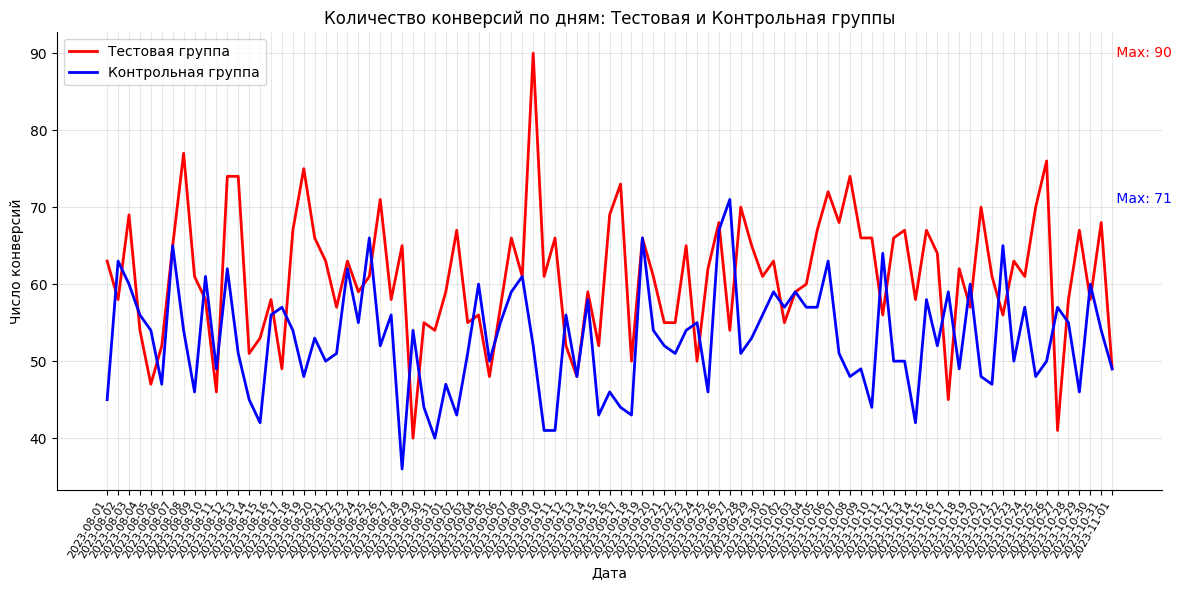

Средние конверсии в день:
Тестовая группа = 61.0;
Контрольная группа = 52.9;
Общая разница = +752 коверсии в тестовой группе;


In [15]:
test_n_by_day = res_by_day[res_by_day['group'] == 'test']
control_n_by_day = res_by_day[res_by_day['group'] == 'control']

plt.figure(figsize=(12, 6))

plt.plot(test_n_by_day['date'], test_n_by_day['converted'],
         color='red', linewidth=2, label='Тестовая группа')

plt.plot(control_n_by_day['date'], control_n_by_day['converted'],
         color='blue', linewidth=2, label='Контрольная группа')

plt.title('Количество конверсий по дням: Тестовая и Контрольная группы')
plt.xlabel('Дата')
plt.ylabel('Число конверсий')
plt.xticks(rotation=60, ha ='right', fontsize = 8)

plt.grid(True, alpha=0.3)

plt.legend()

max_test = test_n_by_day['converted'].max()
max_control = control_n_by_day['converted'].max()

plt.text(test_n_by_day['date'].iloc[-1], max_test, f' Max: {max_test}',
         color='red', va='center')
plt.text(control_n_by_day['date'].iloc[-1], max_control, f' Max: {max_control}',
         color='blue', va='center')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

print("Средние конверсии в день:")
print(f"Тестовая группа = {test_n_by_day['converted'].mean():.1f};")
print(f"Контрольная группа = {control_n_by_day['converted'].mean():.1f};")
print(f"Общая разница = {test_n_by_day['converted'].sum() - control_n_by_day['converted'].sum():+} коверсии в тестовой группе;")

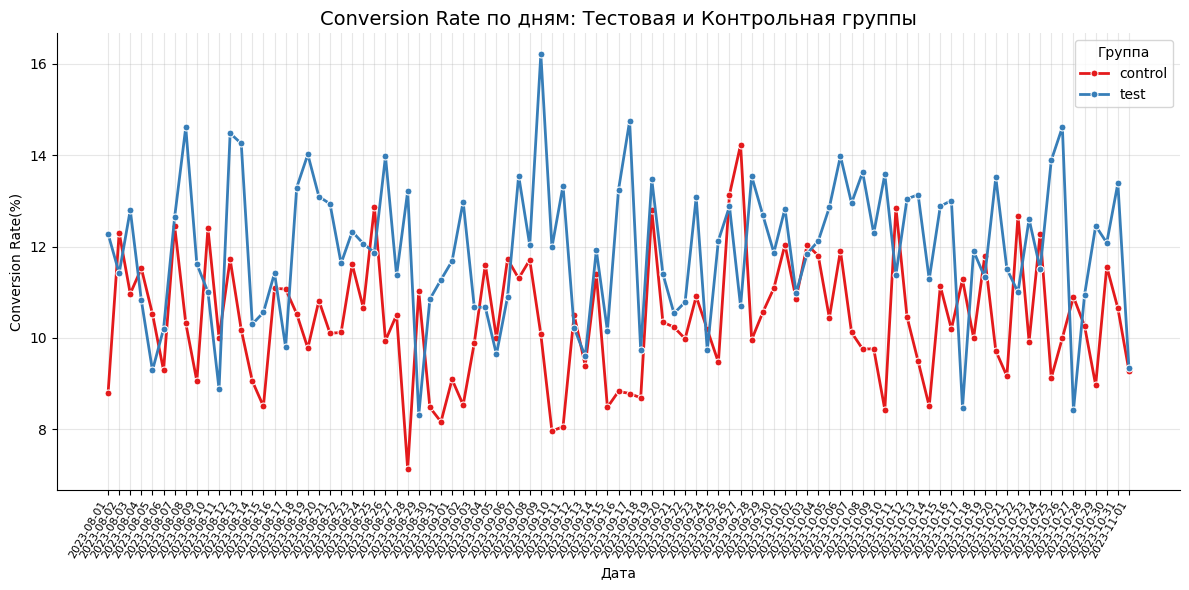

Средний conversion rate:
Тестовая группа: 11.95%
Контрольная группа: 10.40%
Разница: +1.55% в тестовой группе


In [16]:
test_conv_by_date = list(res_by_day_conv.loc[res_by_day_conv['group']=='test']['converted'])
control_conv_by_date = list(res_by_day_conv.loc[res_by_day_conv['group']=='control']['converted'])

plot_data = res_by_day_conv.copy()
plot_data['converted'] = plot_data['converted'] * 100

plt.figure(figsize=(12, 6))

sns.lineplot(data=plot_data, x='date', y='converted', hue='group',
             palette='Set1',
             linewidth=2, marker='o', markersize=5)

plt.title('Conversion Rate по дням: Тестовая и Контрольная группы', fontsize=14)
plt.xlabel('Дата')
plt.ylabel('Conversion Rate(%)')
plt.xticks(rotation=60, ha ='right', fontsize = 8)

plt.grid(True, alpha=0.3)

plt.legend(title='Группа')

sns.despine()

plt.tight_layout()
plt.show()

test_mean = plot_data[plot_data['group'] == 'test']['converted'].mean()
control_mean = plot_data[plot_data['group'] == 'control']['converted'].mean()

print("Средний conversion rate:")
print(f"Тестовая группа: {test_mean:.2f}%")
print(f"Контрольная группа: {control_mean:.2f}%")
print(f"Разница: {test_mean - control_mean:+.2f}% в тестовой группе")

Посмотрим на распределение средних значений по дням в тестовой и котрольной группах.

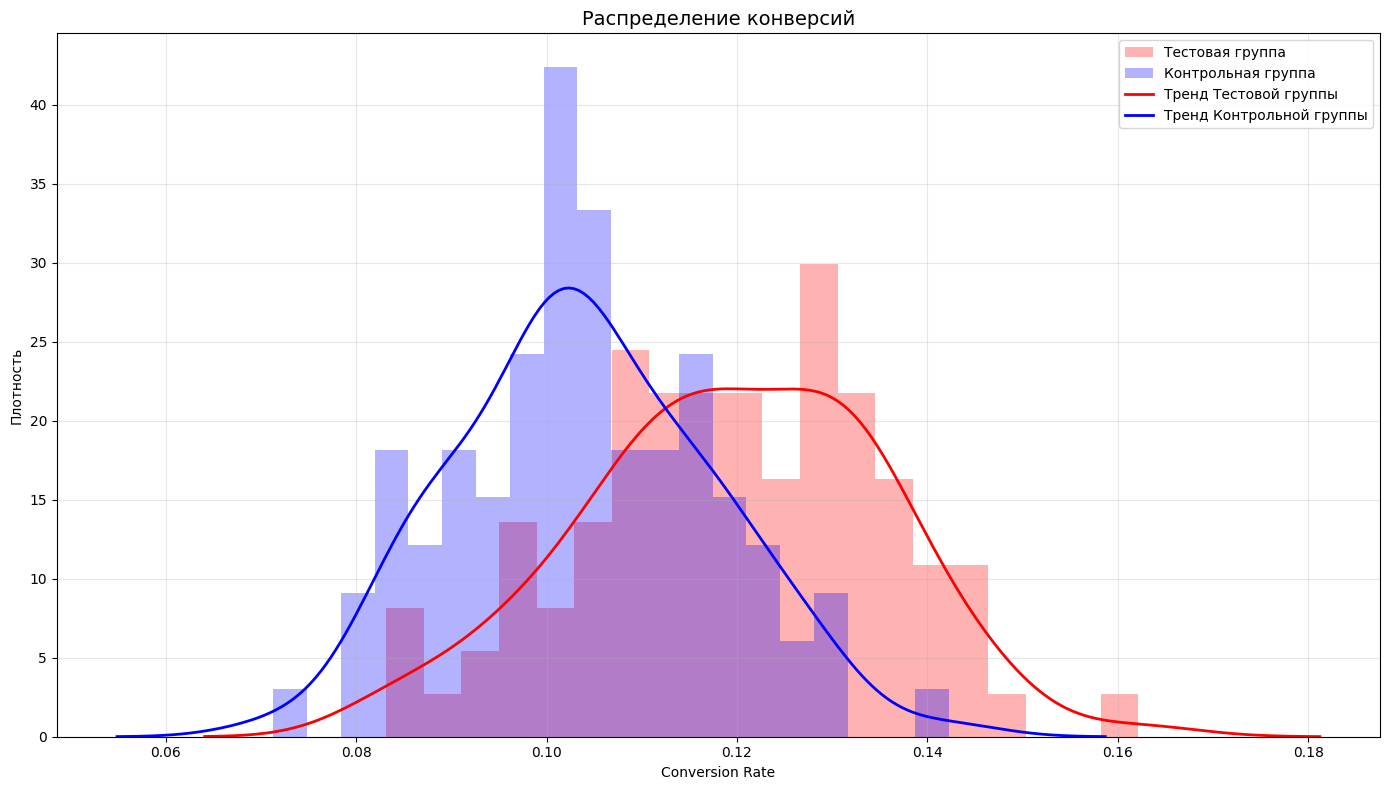

In [17]:
plt.figure(figsize=(14, 8))

plt.hist(test_conv_by_date, bins=20, density=True, color='red', alpha=0.3, label='Тестовая группа')
plt.hist(control_conv_by_date, bins=20, density=True, color='blue', alpha=0.3, label='Контрольная группа')

sns.kdeplot(test_conv_by_date, color='red', linewidth=2, label='Тренд Тестовой группы')
sns.kdeplot(control_conv_by_date, color='blue', linewidth=2, label='Тренд Контрольной группы')

plt.title('Распределение конверсий', fontsize=14)
plt.xlabel('Conversion Rate')
plt.ylabel('Плотность')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Видим, что распределение данных близко к нормальному, значит мы можем использовать параметрические критерии.
Применим к нашим данным Т-тест.

In [18]:
ttest_ind(test_conv_by_date, control_conv_by_date)

TtestResult(statistic=np.float64(7.209029622736518), pvalue=np.float64(1.4124701519287306e-11), df=np.float64(184.0))

Значение pvalue = 1.4124701519287306e-11 = 0.000 - крайне маленькое. Это говорит нам о сильнейшей статистической значимости, следовательно, мы можем с вероятностью 99% доверять полученному результату конверсии.


---

Рассчитаем можность теста.

In [21]:
effect_size = (np.mean(test_conv_by_date) - np.mean(control_conv_by_date)) / np.sqrt(
    (np.var(test_conv_by_date, ddof=1) + np.var(control_conv_by_date, ddof=1)) / 2
)

power = TTestIndPower().solve_power(
    effect_size=effect_size,
    nobs1=len(test_conv_by_date),
    alpha=0.05,
    alternative='two-sided'
)

print(f"Анализ мощности теста:")
print(f"Размер эффекта Cohen's d: {effect_size:.3f}")
print(f"Мощность теста: {power:.3f}")

if power > 0.8:
    print("Мощность теста достаточна (> 0.8)")
else:
    print("Мощность теста недостаточна для обнаружения эффекта")

mde = TTestIndPower().solve_power(
    effect_size=None,
    nobs1=len(test_conv_by_date),
    alpha=0.05,
    power=0.8,
    alternative='two-sided'
)
print(f"Минимальный обнаруживаемый эффект (MDE): {mde:.3f}")

Анализ мощности теста:
Размер эффекта Cohen's d: 1.057
Мощность теста: 1.000
Мощность теста достаточна (> 0.8)
Минимальный обнаруживаемый эффект (MDE): 0.413


# Выводы

1. **Основной результат:**

Тестовая группа показала статистически значимое улучшение конверсии на 14.99% по сравнению с контрольной группой.

Оба статистических теста (биномиальный и t-тест) показали чрезвычайно низкие p-values (6.51e-35 и 1.41e-11), что указывает на высокую надежность результатов.

2. **Статистическая значимость:**

- P-value < 0.000000000001 - вероятность ложного положительного результата ничтожна;

- Результат значим на любом уровне значимости;

- Распределения близки к нормальным, что допускает использование параметрических тестов;

3. **Мощность теста и размер эффекта**
- Мощность теста: 1.000 Можем на 100% доверять результату;
- Размер эффекта Cohen's d: 1.057 говорит об очень большом эффекте;

4. **Практическая значимость:**

- Средний conversion rate: Тестовая = 11.95%, Контрольная = 10.4%;

- Абсолютная разница: +14.99% конверсий в тестовой группе;

- На 10,000 пользователей: +160 дополнительных конверсий;

- Эффект устойчив во времени;

5. **Рекомендации**:
-  Внедрить изменения тестовой группы на всех пользователей;
-  Мониторить ключевые метрики в течение 2 недель после внедрения;
-  Провести дополнительный анализ сегментов пользователей;

6. **Риски**
- Возможны сезонные эффекты;
- Необходимо учитывать другие изменения в продукте;
